# MY NOTEBOOK

## CONFIG

In [1]:
%load_ext autoreload
%autoreload
%reload_ext autoreload

### Imports

In [2]:
# Is this useful ? >> I think yes to avaoid taking all ressources available from the 4 GPUs
from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# The GPU id to use, usually either "0" or "1"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [3]:
#import os
import fnmatch
import re
import random
import time
import sys
import warnings

import librosa
import tensorflow as tf

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 

import itertools

#import progressbar
from tqdm import tqdm_notebook as tqdm
from time import sleep

In [4]:
from models import *
from tools import *
from loading import * 
from labels_analysis import *
from train import *

## Constants

### Local Machine

In [5]:
MTT_DIR = "../MTT/"
DATA_DIRECTORY = MTT_DIR + "dataset/"
WAV_DIRECTORY = MTT_DIR + "wav-dataset/"

# CSV containing song details (title, artist, id, mp3_path,...)
CLIP_INFO_FINAL = "clip_info_final.csv"
# CSV containg the labels (clip_id, labels, mp3_path)
ANNOTATIONS_FINAL = "annotations_final.csv"
# CSV : what is it useful for ?
COMPARISONS_FINAL = "comparisons_final.csv"
LABELS_FILE = MTT_DIR + ANNOTATIONS_FINAL

LOGDIR = "checkpoints/"

### LTS2 Server

This cell defines all the needed data paths, when running on LTS2 server.
Don't run this cell if you are not running the jupyter notebook on the LTS2 server ! (will overwrite the variables defined on the cell above).

You can either create a cell with your own paths, or modify the cell above with your custom paths.

In [6]:
MTT_DIR = "/mnt/scratch/students/jjgweber-MagnaTagATune/"
DATA_DIRECTORY = MTT_DIR + "dataset/"
WAV_DIRECTORY = MTT_DIR + "wav-dataset/"

# CSV containg the labels (clip_id, labels, mp3_path)
ANNOTATIONS_FINAL = "annotations_final.csv"

LABELS_FILE = MTT_DIR + ANNOTATIONS_FINAL

# need to create this directory on the server !!
LOGDIR = "checkpoints/"

### Data

In [ ]:
FILE_NB = 25880 #25863
FILE_LENGTH = 465984

BASIC_CONFIG = {'numOutputNeurons':500,
               'nb_batch':9,
               'batch_size:':int(FILE_LENGTH/BATCH_NB),
               'sample':50,
               'group_size':20,
               'sample_rate':None,
               'train_dir':'0123456789abc',
               'test_dir':'def',
               'learning_rate':0.001,
               'epochs':10,
               'labels_name':['piano', 'rock'],
               'nb_labels':2}

In [7]:
FILE_NB = 25880 #25863
FILE_LENGTH = 465984
# 465984 = 2 × 2 × 2 × 2 × 2 × 2 × 3 × 3 × 809
# useful for batches > for now divide by 9 (instead of 10)

BATCH_NB = 9
BATCH_SIZE = int(FILE_LENGTH/BATCH_NB)
SAMPLE_SIZE = 0
SAMPLE_RATE = 16000
RECEPTIVE_FIELD = 0

TRAIN_DIR = "0123456789abcde"
TEST_DIR ="f"

BASIC_CONFIG ={'numOutputNeurons':500}
LEARNING_RATE = 0.001

### Mutable parameters

In [8]:
# Variables which are often modified to test the algorithm
NB_SONGS = 20
GROUP_SIZE = 20
EPOCHS = 16 # check in paper
LABELS_NAME = ['guitar', 'techno']
NB_LABELS = len(LABELS_NAME)

# use for post-processing > merge predictions of the 9 pieces by majority vote
threshold_tag = 0.7
majority = 9

## Prediction labels

### Load and clean

In [9]:
labels, header = load_and_clean_labels(LABELS_FILE)
#labels.head(5)

/home/jjgweber/pds/loading.py:221: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  labels = pd.read_csv(labels_path, sep = '"\t"')


Loading csv file : 3.07


### Analyse the dataset

In [10]:
nb_labels_per_song, nb_song_per_label, label_header_by_freq = label_stats(labels, header, plot=False)

Number of songs :  25863
Number of labels :  188
Max number of songs tagged with the same label :  4852
Max number of labels for a single song :  27


In [11]:
best_10_labels = label_header_by_freq[:10]
best_30_labels = label_header_by_freq[:30]

### Co-occurence matrix


label_header_with_count: ['guitar (4852)', 'classical (4272)', 'slow (3547)', 'techno (2954)', 'strings (2729)', 'drums (2598)', 'electronic (2519)', 'rock (2371)', 'fast (2306)', 'piano (2056)']


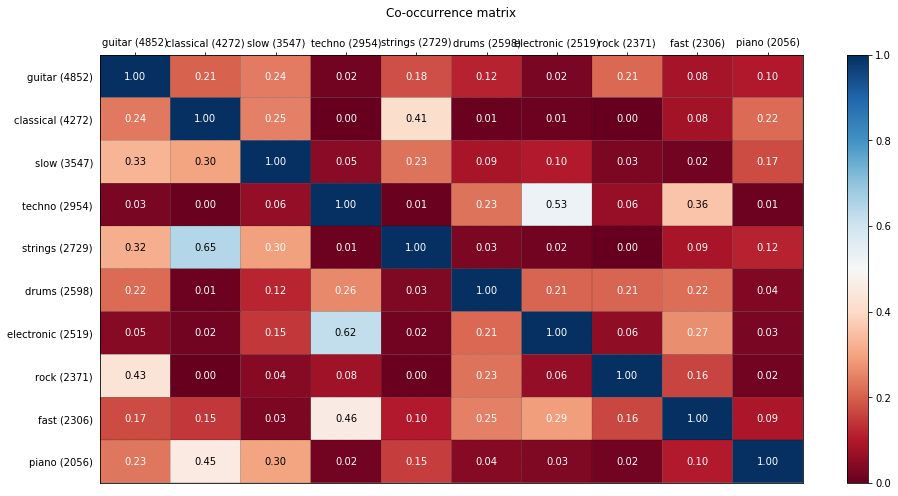

In [12]:
chosen_labels = best_10_labels
check_overlaps(chosen_labels, labels.loc[:,chosen_labels].values.astype(int))

## Load and format mp3 data

## Neural network

### Training

In [13]:
# training variables 
TRAIN_DIR = "0123456789abc"
TEST_DIR = "def"
EPOCHS = 10
BATCH_NB = 9
BATCH_SIZE = int(FILE_LENGTH/BATCH_NB)
#LOGDIR =
#LABELS_NAME = ['guitar', 'techno']
LABELS_NAME = ['piano', 'rock']
NB_LABELS = len(LABELS_NAME)
LEARNING_RATE = 0.001
GROUP_SIZE = 10
SAMPLE_SIZE = 50

In [14]:
data_dir, pattern, file_type = return_params_mp3_wav("mp3", DATA_DIRECTORY, WAV_DIRECTORY)
# also need labels but computed above

In [15]:
def initialize_tf_model(input_shape, nb_labels, nb_batch, batch_size, learning_rate, is_training=True) :
    print("Initialize tf model ...")
    tf.reset_default_graph()

    x = tf.placeholder(tf.float32, shape=(input_shape*nb_batch, batch_size, 1))
    y = tf.placeholder(tf.float32, shape=(input_shape*nb_batch, nb_labels))

    net = build_model(x, is_training=is_training, config=BASIC_CONFIG) 
    predictions = tf.layers.dense(net, nb_labels, activation=tf.sigmoid)
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = y, logits = predictions)
    reduced_loss = tf.reduce_mean(loss)
    train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(reduced_loss)
    auc = tf.metrics.auc(labels = y, predictions=predictions)
    
    # Saver for storing checkpoints of the model. (Wavenets)
    saver = tf.train.Saver(var_list=tf.global_variables())
    
    return x, y, net, predictions, loss, reduced_loss,  train_op, auc, saver

In [17]:
def train(data_dir, group_size, sample_size, file_type, train_dir, epochs, \
          labels, labels_name, nb_labels, batch_size, nb_batch, logdir, learning_rate) :
    
    pattern = ""
    if file_type == "mp3" :
        pattern = "*.mp3"
    else :
        if file_type == "wav" :
            pattern = "*.wav"
        else :
            print("Argument should be either \"mp3\" or \"wav\".")
        
    # keep results for plotting
    train_loss_results = []
    train_auc_results = []


    files_by_group = find_files_group_select(data_dir, labels, labels_name, group_size, sample=sample_size, \
                                             pattern=pattern, sub_dir=train_dir)
    
    n_groups = len(files_by_group)
    #print(data_dir, labels, labels_name, group_size)

    x, y, net, predictions, loss, reduced_loss, \
    train_op, auc, saver = initialize_tf_model(len(files_by_group[0]), nb_labels, nb_batch,\
                                               batch_size, learning_rate)
    print("Start training...")

    start = time.time()

    with tf.Session() as sess:

        init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

        sess.run(init)

        # Go through the whole DS at each EPOCH
        for epoch in tqdm(range(epochs)):

            t0_epoch = time.time()

            # Group by group
            for count, g in enumerate(files_by_group) :

                # Load audio and labels
                tload0 = time.time()
                audios, tags = load_audio_label_aux(labels, g, len(data_dir), labels_name=labels_name, \
                        nb_labels=nb_labels, file_type=file_type, batch_size=batch_size, nb_batch=nb_batch)
                
                tload1 = time.time()

                if count==0 :
                    print(">> Total loading time : {:.2f} sec".format(tload1-tload0))
                #audio_tf = tf.convert_to_tensor(audios, np.float32)

                # add check to verify if there is something to restore
                #saver.restore(sess, LOGDIR)
                
                predict, _, loss_value, auc_score = sess.run([predictions, train_op, reduced_loss, auc],\
                                                             feed_dict={x: audios, y: tags})
                
                auc_result, update_op = auc_score

                saver.save(sess, logdir)


                train_loss_results.append(loss_value)
                train_auc_results.append(auc_result)

                if (count % 20) == 0 :
                    print("Group {} done. {} left.".format(count, n_groups-count-1))


            t1_epoch = time.time()

            dur = t1_epoch-t0_epoch

            print("Iter: {:3}, Time (in sec): {:.2f}, Loss: {:.4f}, AUC : {:.4f}"\
                  .format(epoch, dur, loss_value, auc_result))
            print()

    end = time.time()
    duration2 = end-start
    print("Total time: {:.2f} sec.".format(duration2))
    return train_loss_results, train_auc_results

In [18]:
def train_all(group_size) :
    train_loss_results, train_auc_results = train(data_dir, group_size, None, file_type,\
                                                  TRAIN_DIR, EPOCHS, labels, LABELS_NAME, NB_LABELS, \
                                                  BATCH_SIZE, BATCH_NB, LOGDIR, LEARNING_RATE)
    return train_loss_results, train_auc_results

In [19]:
def train_input_shape(group_size, sample_size) :
    train_loss_results, train_auc_results = train(data_dir, group_size, sample_size, file_type,\
                                                  TRAIN_DIR, EPOCHS, labels, LABELS_NAME, NB_LABELS, \
                                                  BATCH_SIZE, BATCH_NB, LOGDIR, LEARNING_RATE)
    return train_loss_results, train_auc_results

In [20]:
def train_labels_choice(labels_name, nb_labels) :
    train_loss_results, train_auc_results = train(data_dir, GROUP_SIZE, SAMPLE_SIZE, file_type, \
                                                  TRAIN_DIR, EPOCHS, labels, labels_name, nb_labels, \
                                                  BATCH_SIZE, BATCH_NB, LOGDIR, LEARNING_RATE)
    return train_loss_results, train_auc_results

In [21]:
def train_learning_rate(l_rate) :
    train_loss_results, train_auc_results = train(data_dir, group_size, sample_size, file_type, \
                                                  TRAIN_DIR, EPOCHS, labels, labels_name, nb_labels, \
                                                  BATCH_SIZE, BATCH_NB, LOGDIR, l_rate)
    return train_loss_results, train_auc_results

In [ ]:
train_loss_results, train_auc_results = train_input_shape(20, 3360)

All labels : 25863 songs >>> Selected for given labels : 4387. (test or train sets are note taken    into account here)
Initialize tf model ...
Start training...


>> Total loading time : 8.52 sec
Group 0 done. 167 left.
Group 20 done. 147 left.
Group 40 done. 127 left.
Group 60 done. 107 left.
Group 80 done. 87 left.
Group 100 done. 67 left.
Group 120 done. 47 left.
Group 140 done. 27 left.
Group 160 done. 7 left.
Iter:   0, Time (in sec): 1981.77, Loss: 0.5867, AUC : 0.8941

>> Total loading time : 11.22 sec
Group 0 done. 167 left.
Group 20 done. 147 left.
Group 40 done. 127 left.
Group 60 done. 107 left.
Group 80 done. 87 left.
Group 100 done. 67 left.
Group 120 done. 47 left.
Group 140 done. 27 left.
Group 160 done. 7 left.
Iter:   1, Time (in sec): 2060.51, Loss: 0.5482, AUC : 0.8908

>> Total loading time : 11.16 sec
Group 0 done. 167 left.
Group 20 done. 147 left.
Group 40 done. 127 left.
Group 60 done. 107 left.
Group 80 done. 87 left.
Group 100 done. 67 left.
Group 120 done. 47 left.
Group 140 done. 27 left.
Group 160 done. 7 left.
Iter:   2, Time (in sec): 2111.35, Loss: 0.5562, AUC : 0.8926

>> Total loading time : 11.64 sec
Group 0 do

In [ ]:
train_loss_results, train_auc_results = train_all(20)

In [ ]:
plot_auc_loss(train_loss_results, train_auc_results)

## Testing

In [ ]:
test_size = 10

test_files = find_files_group(data_dir, test_size, sample=test_size, pattern=pattern, sub_dir=TEST_DIR)

audios_test, tags_test = load_audio_label_aux(labels, test_files[0], len(data_dir), labels_name=LABELS_NAME, \
                        nb_labels=NB_LABELS, file_type=file_type, batch_size=BATCH_SIZE, nb_batch=BATCH_NB)
#audios_test_tf = tf.convert_to_tensor(audios_test, np.float32)

# for testing I guess no need to give several groups to the network ?


In [ ]:
x, y, net, predictions, loss, reduced_loss,  train_op, auc, saver = initialize_tf_model(len(test_files[0]), \
                                                                                        is_training=False)

In [ ]:
variables_to_restore = {
    var.name[:-2]: var for var in tf.global_variables()
    if not ('state_buffer' in var.name or 'pointer' in var.name)}

# Add ops to save and restore all the variables.
saver = tf.train.Saver(variables_to_restore)

# Later, launch the model, use the saver to restore variables from disk, and
# do some work with the model.
with tf.Session() as sess:
      # Restore variables from disk.
    saver.restore(sess, LOGDIR)
    print("Model restored.")
    
    init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

    sess.run(init) 

    predicts = sess.run([predictions, train_op, reduced_loss, auc], \
                        feed_dict={x: audios_test, y: tags_test})

In [ ]:
# Print some results 
print("AUC Score :", predicts[3])

In [ ]:
print("PREDICTIONS :", predicts[0])
print("TRUE :", tags_test)

Following TF tutorial for custom training
https://github.com/tensorflow/docs/blob/master/site/en/tutorials/eager/custom_training_walkthrough.ipynb

# OLD STUFF

In [ ]:
data_dir, pattern, file_type = return_params_mp3_wav("mp3", DATA_DIRECTORY, WAV_DIRECTORY)
group_size, sample_size =10, 50
train(data_dir, group_size, sample_size, file_type, TRAIN_DIR, EPOCHS, labels, LABELS_NAME, NB_LABELS, \
     BATCH_SIZE, BATCH_NB, LOGDIR, LEARNING_RATE)

In [ ]:
# VERSION 2 : feed group by group
def train_v2(group_size=10, sample_size=50):

    files_by_group = find_files_group(data_dir, group_size, sample=sample_size, pattern=pattern, sub_dir=TRAIN_DIR)
    n_groups = len(files_by_group)

    x, y, net, predictions, loss, reduced_loss,  train_op, auc, saver = initialize_tf_model()

    print("Start training...")

    start = time.time()

    with tf.Session() as sess:

        init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

        sess.run(init)

        # Go through the whole DS at each EPOCH
        for epoch in tqdm(range(EPOCHS)):

            t0_epoch = time.time()

            # Group by group
            for count, g in enumerate(files_by_group) :

                # Load audio and labels
                tload0 = time.time()
                audios, tags = load_audio_label_aux(labels, g, len(data_dir), labels_name=LABELS_NAME, \
                        nb_labels=NB_LABELS, file_type=file_type, batch_size=BATCH_SIZE, nb_batch=BATCH_NB)
                tload1 = time.time()

                if count==0 :
                    print(">> Total loading time : {:.2f} sec".format(tload1-tload0))
                #audio_tf = tf.convert_to_tensor(audios, np.float32)

                # add check to verify if there is something to restore
                #saver.restore(sess, LOGDIR)

                predict, _, loss_value, auc_score = sess.run([predictions, train_op, reduced_loss, auc],\
                                                             feed_dict={x: audios, y: tags})
                auc_result, update_op = auc_score

                saver.save(sess, LOGDIR)


                train_loss_results.append(loss_value)
                train_auc_results.append(auc_result)

                print("Group {} done. {} left.".format(count, n_groups-count))


            t1_epoch = time.time()

            dur = t1_epoch-t0_epoch

            print("Iter: {:3}, Time (in sec): {:.2f}, Loss: {:.4f}, AUC : {:.4f}"\
                  .format(epoch, dur, loss_value, auc_result))
            print()

        end = time.time()
        duration2 = end-start
        print("Total time: {:.2f} sec.".format(duration2))


## Load and format mp3 data 

### Loading audio & tags

In [ ]:
''' Use Example 
 load audios and labels > convert to numpy
 CAREFUL : the argument num_songs is important and shouldn't be too big 
 > otherwise MEMORY ISSUES !!!!!!

audios, tags, order, order2 = load_audio_label(cleaned, num_songs=NB_SONGS, sub_dir=TRAIN_DIR, \
                                file_type="mp3", directory=DATA_DIRECTORY, randomize_batch=True) '''

def load_audio_label(labels, num_songs, sample_rate=None, directory=WAV_DIRECTORY, \
                     labels_name=LABELS_NAME, sub_dir=None, file_type="wav", randomize_batch=False):
    
    assert (file_type=="wav" or file_type=="mp3"), "The argument file_type should be either 'wav', either 'mp3'."
    if (file_type=="wav" and directory!=WAV_DIRECTORY) or (file_type=="mp3" and directory!=DATA_DIRECTORY):
        warnings.warn("File type and directory may not correspond. Make sure the \
        directory gave as parameter contains the right type of files", FutureWarning, stacklevel=2)
        
    if num_songs > 20 :
        warnings.warn("The argument num_song should not be too high (above 20), make sure this will \
        not cause memory error.", FutureWarning, stacklevel=2)
       
    
    print("Loading data ...")
    start = time.time()
    
    if file_type=="mp3" :
        files = find_files(directory, sample=num_songs, sub_dir=sub_dir)
    if file_type=="wav" :
        files = find_files(directory, sample=num_songs, sub_dir=sub_dir, pattern='*.wav')
 
    randomized_files = randomize_files(files)
    
    count = 0
    
    audios = np.ndarray(shape=(num_songs * BATCH_NB, BATCH_SIZE, 1), dtype=np.float32, order='F')
    tags = np.ndarray(shape=(num_songs * BATCH_NB, NB_LABELS), dtype=np.float32, order='F')
    order = np.zeros(num_songs * BATCH_NB, dtype=int)
    order2 = np.zeros(num_songs * BATCH_NB, dtype=int)
    
    idx = 0
    
    for filename in randomized_files:

        # Load audio (MP3/WAV) file        
        try :
            audio, _ = librosa.load(filename, sr=sample_rate, mono=True)
        except EOFError :
            print("EOFERROR : The following file could not be loaded with librosa - ", filename)

        audio = audio.reshape(-1, 1)
         
        for n in range(BATCH_NB) :
            audios[idx] = audio[n*BATCH_SIZE: (n+1)*BATCH_SIZE,:]
            
            # take labels or corresponding song
            
            if file_type=="mp3" :
                select_labels  = labels.loc[labels['mp3_path']==filename[len(directory):]]
            
            if file_type=="wav" :
                select_labels  = labels.loc[labels['mp3_path']==filename[len(directory):-4]+".mp3"]

            # select wanted labels
            select_labels = select_labels[labels_name]

            tags[idx] = select_labels.values.reshape(NB_LABELS)
            
            order[idx] = count
            order2[idx] = idx
            idx +=1
        
        count +=1
        if (count % 10) == 0:
            print(count)
    
    if randomize_batch :
        rng_state = np.random.get_state()
        np.random.shuffle(audios)
        np.random.set_state(rng_state)
        np.random.shuffle(tags)
        np.random.set_state(rng_state)
        np.random.shuffle(order)
        np.random.set_state(rng_state)
        np.random.shuffle(order2)
        
    end = time.time()
    duration = end-start
    print(">> Total loading time - {} songs : {:.2f} sec".format(num_songs, duration))
    print()
    print("Shape of audios list :", audios.shape)
    print("Shape of tags list :", tags.shape)
    return audios, tags, order, order2

In [ ]:
# This one is not correct yet I think
def load_audio_label_prim(labels, num_songs, sample_rate=None, directory=WAV_DIRECTORY, \
                     labels_name=LABELS_NAME, sub_dir=None, file_type="wav", randomize_batch=False):
    
    
    assert (file_type=="wav" or file_type=="mp3"), "The argument file_type should be either 'wav', either 'mp3'."
    if (file_type=="wav" and directory!=WAV_DIRECTORY) or (file_type=="mp3" and directory!=DATA_DIRECTORY):
        warnings.warn("File type and directory may not correspond. Make sure the \
        directory gave as parameter contains the right type of files", FutureWarning, stacklevel=2)
        
    if num_songs > 20 :
        warnings.warn("The argument num_song should not be too high (above 20), make sure this will \
        not cause memory error.", FutureWarning, stacklevel=2)
        
    print("Loading data ...")
    start = time.time()
    
    if group_size != None:
        if file_type=="mp3" :
            files = find_files_group(directory, group_size, sample=num_songs, sub_dir=sub_dir, pattern='*.mp3')
        if file_type=="wav" :
            files = find_files_group(directory, group_size, sample=num_songs, sub_dir=sub_dir, pattern='*.wav')
    
    else :
        if file_type=="mp3" :
            files = find_files(directory, sample=num_songs, sub_dir=sub_dir, pattern='*.mp3')
        if file_type=="wav" :
            files = find_files(directory, sample=num_songs, sub_dir=sub_dir, pattern='*.wav')
            
    randomized_files = randomize_files(files)
    
    count = 0
    
    audios = np.ndarray(shape=(num_songs * BATCH_NB, BATCH_SIZE, 1), dtype=np.float32, order='F')
    tags = np.ndarray(shape=(num_songs * BATCH_NB, NB_LABELS), dtype=np.float32, order='F')
    order = np.zeros(num_songs * BATCH_NB, dtype=int)
    order2 = np.zeros(num_songs * BATCH_NB, dtype=int)
    

    
    if group_size != None :
        for group in files :
            load_audio_label_aux(cleaned, group, len(directory), labels_name=labels_name, file_type=file_type)
    
    # check where to put this after        
    if randomize_batch :
        rng_state = np.random.get_state()
        np.random.shuffle(audios)
        np.random.set_state(rng_state)
        np.random.shuffle(tags)
        np.random.set_state(rng_state)
        np.random.shuffle(order)
        np.random.set_state(rng_state)
        np.random.shuffle(order2)
        
    end = time.time()
    duration = end-start
    print(">> Total loading time - {} songs : {:.2f} sec".format(num_songs, duration))
    print()
    print("Shape of audios list :", audios.shape)
    print("Shape of tags list :", tags.shape)
    return audios, tags, order, order2

## Neural Network model

### Save neural net state tool

In [ ]:
# not used for now
def save(saver, sess, logdir, step):
    model_name = 'model.ckpt'
    checkpoint_path = os.path.join(logdir, model_name)
    print('Storing checkpoint to {} ...'.format(logdir), end="")
    sys.stdout.flush()

    if not os.path.exists(logdir):
        os.makedirs(logdir)

    saver.save(sess, checkpoint_path, global_step=step)
    print(' Done.')

In [ ]:
# clean argument passing
def merge_predictions(predictions, order, num_songs = NB_SONGS, threshold=0.5, majority=5):
    print("ORD:",order)
    print(type(predictions[0]))
    #tf.map_fn(tf.invert_permutation, (predictions, order))
    ordered = tf.gather(predictions, indices=order, axis=0)
    
    new_predictions = np.zeros(num_songs * BATCH_NB, dtype= np.float32)
    
    count1 = 0
    for b in range(BATCH_NB) :
        if ordered[b] > threshold :
            count1 +=1
            
    if count1 >= majority :
        for b in range(BATCH_NB) :
            new_predictions[b] = 1
    
    return tf.convert_to_tensor(new_predictions, np.float32)

### Training

In [ ]:
# run this cell everytime before relaunching tensorflow session
tf.reset_default_graph()

In [ ]:
# VERSION 1 : DOESN'T HANDLE GROUPS - feeds all sample of given size to the network 

def train_v1() :
    
    # keep results for plotting
    train_loss_results = []
    train_auc_results = []

    print("Initializing tf model ...")

    audio_tf= tf.convert_to_tensor(audios, np.float32)
    print("Input shape : {}".format(audio_tf.shape))
    print("Labels : {}".format(tags.flatten()))
    print()

    net = build_model(audio_tf, is_training=True, config=BASIC_CONFIG) 
    predictions = tf.layers.dense(net, NB_LABELS, activation=tf.sigmoid)
    #predictions = merge_predictions(predictions, order2)
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = tags, logits = predictions)
    reduced_loss = tf.reduce_mean(loss)
    train_op = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(reduced_loss)
    auc = tf.metrics.auc(labels = tags, predictions=predictions)


    # Saver for storing checkpoints of the model. (Wavenets)
    saver = tf.train.Saver(var_list=tf.global_variables())

    print("Start training...")

    start = time.time()

    with tf.Session() as sess:

        init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

        sess.run(init)

        for epoch in tqdm(range(EPOCHS)):
            t0_epoch = time.time()
            predict, _, loss_value, auc_score = sess.run([predictions, train_op, reduced_loss, auc])
            #print(type(predict))
            auc_result, update_op = auc_score

            train_loss_results.append(loss_value)
            train_auc_results.append(auc_result)

            t1_epoch = time.time()
            dur = t1_epoch-t0_epoch
            print("Iter: {:3}, Time (in sec): {:.2f}, Loss: {:.4f}, AUC : {:.4f}".format(epoch,\
                                                                                        dur, \
                                                                                         loss_value, auc_result))
            #print("Predictions : {}".format(predict.flatten()))
            #print()

        # use wavenet function > see later (for now simplest way)
        #save(saver, sess, LOGDIR, EPOCHS)
        saver.save(sess, LOGDIR)

    end = time.time()
    duration2 = end-start
    print("Total time: {:.2f} sec.".format(duration2))
    
    return train_loss_results, train_auc_results

In [ ]:
#import wave
#files_by_group = find_files_group(WAV_DIRECTORY, GROUP_SIZE, pattern='*.wav', sub_dir=TRAIN_DIR)

#for g in files_by_group:
  #  for f in g :
   #     print(f)
    #    audio = wave.open(f, mode='rb')
     #   print(audio.getparams())

### Initialization

In [ ]:
def experiment1():
    GROUP_SIZE=10

    files_by_group = find_files_group(WAV_DIRECTORY, GROUP_SIZE, pattern='*.wav', sub_dir=TRAIN_DIR)

    print("Initialize tf model ...")

    x = tf.placeholder(tf.float32, shape=(len(files_by_group[0])*BATCH_NB, BATCH_SIZE, 1))
    y = tf.placeholder(tf.float32, shape=(len(files_by_group[0])*BATCH_NB, NB_LABELS))

    net = build_model(x, is_training=True, config=BASIC_CONFIG) 
    predictions = tf.layers.dense(net, NB_LABELS, activation=tf.sigmoid)
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = y, logits = predictions)
    reduced_loss = tf.reduce_mean(loss)
    train_op = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(reduced_loss)
    auc = tf.metrics.auc(labels = y, predictions=predictions)

    # Saver for storing checkpoints of the model. (Wavenets)
    saver = tf.train.Saver(var_list=tf.global_variables())

    print("Start training...")

    start = time.time()

    with tf.Session() as sess:

        init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

        sess.run(init)

        # Go through the whole DS at each EPOCH
        for epoch in tqdm(range(EPOCHS)):

            t0_epoch = time.time()

            # Group by group
            for g in files_by_group :

                # Load audio and labels
                audios, tags = load_audio_label_aux(cleaned, g, len(WAV_DIRECTORY), labels_name=LABELS_NAME, \
                        nb_labels=NB_LABELS, file_type="wav", batch_size=BATCH_SIZE, nb_batch=BATCH_NB)

                #audio_tf = tf.convert_to_tensor(audios, np.float32)

                # add check to verify if there is something to restore
                #saver.restore(sess, LOGDIR)

                predict, _, loss_value, auc_score = sess.run([predictions, train_op, reduced_loss, auc],\
                                                             feed_dict={x: audios, y: tags})
                auc_result, update_op = auc_score

                saver.save(sess, LOGDIR)


                train_loss_results.append(loss_value)
                train_auc_results.append(auc_result)

                print("Group done.")


            t1_epoch = time.time()

            dur = t1_epoch-t0_epoch

            print("Iter: {:3}, Time (in sec): {:.2f}, Loss: {:.4f}, AUC : {:.4f}"\
                  .format(epoch, dur, loss_value, auc_result))



        end = time.time()
        duration2 = end-start
        print("Total time: {:.2f} sec.".format(duration2))


## Test set

In [ ]:
tf.reset_default_graph()

In [ ]:
TEST_SIZE = 10

audios_test, tags_test, order_test, order_test2 = load_audio_label(cleaned, num_songs=TEST_SIZE, sub_dir=TEST_DIR)

audios_test_tf = tf.convert_to_tensor(audios_test, np.float32)

In [ ]:
net = build_model(audio_tf, is_training=False, config=BASIC_CONFIG) 
predictions = tf.layers.dense(net, NB_LABELS, activation=tf.sigmoid)
#predictions = merge_predictions(predictions, order2)
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = tags, logits = predictions)
reduced_loss = tf.reduce_mean(loss)
train_op = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(reduced_loss)
auc = tf.metrics.auc(labels = tags, predictions=predictions)

In [ ]:
variables_to_restore = {
    var.name[:-2]: var for var in tf.global_variables()
    if not ('state_buffer' in var.name or 'pointer' in var.name)}

# Add ops to save and restore all the variables.
saver = tf.train.Saver(variables_to_restore)

# Later, launch the model, use the saver to restore variables from disk, and
# do some work with the model.
with tf.Session() as sess:
      # Restore variables from disk.
    saver.restore(sess, LOGDIR)
    print("Model restored.")
    
    init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

    sess.run(init) 

    predicts = sess.run([audios_test_tf, predictions, train_op, reduced_loss, auc])

In [ ]:
# Print some results 
print("AUC Score :", predicts[4])

In [ ]:
print("PREDICTIONS :", predicts[1])
print("TRUE :", tags_test)

Following TF tutorial for custom training
https://github.com/tensorflow/docs/blob/master/site/en/tutorials/eager/custom_training_walkthrough.ipynb